In [1]:
from google.colab import files
uploaded = files.upload()

Saving class_inputs.csv to class_inputs.csv
Saving class_outputs.csv to class_outputs.csv


In [2]:
import numpy as np
import csv
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler

from keras.models import Model
from keras import layers
from keras.layers import Input
from keras import optimizers



In [4]:
df_in = pd.read_csv('class_inputs.csv', na_values="NONE" )
df_target = pd.read_csv('class_outputs.csv', na_values="NONE" ) 



IN_X1=df_in.to_numpy()
IN_Y=df_target.to_numpy()


scaler = StandardScaler()
IN_X = scaler.fit_transform(IN_X1[:,2:])
feat_dim = 28


In [5]:
IN_X

array([[-0.01952029, -0.01486324, -0.25921278, ..., -0.18228974,
        -0.42847811, -1.17181785],
       [-0.01963504, -0.0149087 , -0.25921278, ..., -0.18228974,
         2.3338415 , -1.17181785],
       [-0.01955854, -0.01495416, -0.25921278, ..., -0.18228974,
         2.3338415 , -1.1710047 ],
       ...,
       [-0.01959679, -0.01459046, -0.16404937, ..., -0.18228974,
        -0.42847811,  1.88481947],
       [ 0.44046442, -0.01249917, -0.16404937, ..., -0.18228974,
        -0.42847811,  2.44833362],
       [-0.01691935, -0.0149087 , -0.16404937, ..., -0.18228974,
        -0.42847811,  0.09588568]])

In [6]:

IN_train, IN_valid, O_train, O_valid = train_test_split(IN_X.reshape((-1,feat_dim,1)), IN_Y.reshape((-1,1)), test_size=0.1, random_state=1)


O_train_cat=to_categorical(O_train, num_classes = 8)

In [7]:
from sklearn.decomposition import PCA

pca = PCA(.95)
print(IN_train.shape)
pca.fit(IN_train.reshape((-1,28)))
IN_train = pca.transform(IN_train.reshape((-1,28)))
IN_valid = pca.transform(IN_valid.reshape((-1,28)))
new_feat_dim = IN_valid.shape[1]
print(new_feat_dim)

(435183, 28, 1)
20


In [40]:
def Reg_Hadi():
    inputs = Input(shape=(new_feat_dim, 1))
    # x = layers.BatchNormalization()(inputs)
    x = layers.LSTM(256, batch_input_shape=(None, feat_dim, 1),return_sequences=True)(inputs)
    x = layers.LSTM(128,return_sequences=True)(x)
    x = layers.LSTM(64,return_sequences=False)(x)
    x = layers.Dropout(0.25)(x)
    #        x = layers.LSTM(32,return_sequences=True)(x)
    #        x = layers.LSTM(32,return_sequences=True)(x)
    x = layers.Dense(8,activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x, name='Utility2')
    return model


In [44]:
import keras
R_model_H = Reg_Hadi()

# es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)

# R_opt = optimizers.RMSprop(lr=1E-4, epsilon=1e-08,decay=0.8E-6)
R_opt = optimizers.Adam(lr=1E-4)

R_model_H.trainable = True
R_model_H.compile(optimizer=R_opt, loss='categorical_crossentropy',metrics=['accuracy'])

history = R_model_H.fit(IN_train,O_train_cat,epochs=300,batch_size=512, validation_split=0.05)

Epoch 1/300
808/808 [==============================] - 16s 16ms/step - loss: 1.8753 - accuracy: 0.3295 - val_loss: 1.7588 - val_accuracy: 0.3445
Epoch 2/300
808/808 [==============================] - 12s 14ms/step - loss: 1.7582 - accuracy: 0.3512 - val_loss: 1.7086 - val_accuracy: 0.3645
Epoch 3/300
808/808 [==============================] - 11s 14ms/step - loss: 1.7127 - accuracy: 0.3641 - val_loss: 1.6757 - val_accuracy: 0.3715
Epoch 4/300
808/808 [==============================] - 12s 14ms/step - loss: 1.6774 - accuracy: 0.3714 - val_loss: 1.6432 - val_accuracy: 0.3787
Epoch 5/300
808/808 [==============================] - 11s 14ms/step - loss: 1.6461 - accuracy: 0.3810 - val_loss: 1.6283 - val_accuracy: 0.3825
Epoch 6/300
808/808 [==============================] - 11s 14ms/step - loss: 1.6249 - accuracy: 0.3864 - val_loss: 1.5975 - val_accuracy: 0.3994
Epoch 7/300
808/808 [==============================] - 12s 14ms/step - loss: 1.6041 - accuracy: 0.3925 - val_loss: 1.5870 - val_ac

In [45]:
o_train_hat=R_model_H.predict(IN_train)
o_valid_hat=R_model_H.predict(IN_valid)



train_acc=balanced_accuracy_score(O_train.reshape((-1,)),np.argmax(o_train_hat,axis=-1).reshape((-1,)))
valid_acc=balanced_accuracy_score(O_valid.reshape((-1,)),np.argmax(o_valid_hat,axis=-1).reshape((-1,)))

In [46]:
valid_acc

0.3991551018448386

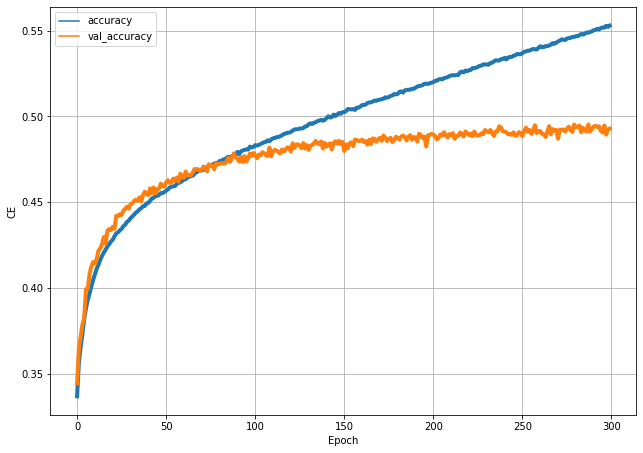

In [61]:
import matplotlib.pyplot as plt

lws = [4, 4]
ax=pd.DataFrame(history.history)

ax_plt = ax[['accuracy','val_accuracy']].plot(figsize=(8, 5))
for i, l in enumerate(ax_plt.lines):
    plt.setp(l, linewidth=lws[i])
plt.grid(True)
plt.ylabel('CE')
plt.xlabel('Epoch')
plt.rc('font', size=25)
plt.rc('axes', titlesize=25)
fig = plt.gcf()
fig.set_size_inches(10.5, 7.5)
fig.savefig('MSE.png', dpi=600,bbox_inches = 'tight')
plt.show()

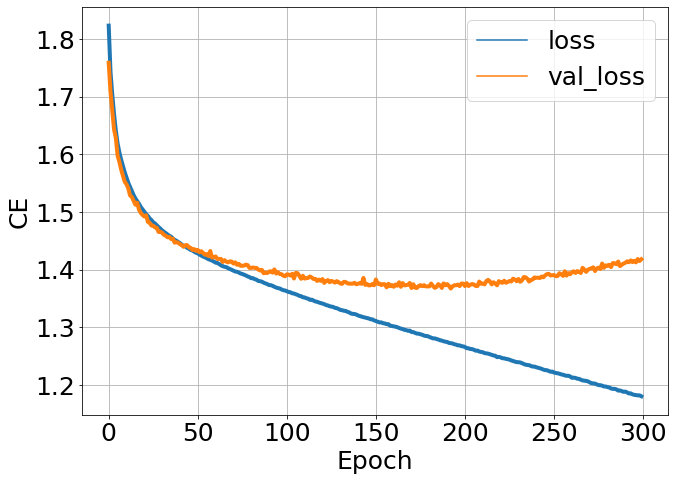

In [62]:
import matplotlib.pyplot as plt

lws = [4, 4]
ax=pd.DataFrame(history.history)

ax_plt = ax[['loss','val_loss']].plot(figsize=(8, 5))
for i, l in enumerate(ax_plt.lines):
    plt.setp(l, linewidth=lws[i])
plt.grid(True)
plt.ylabel('CE')
plt.xlabel('Epoch')
plt.rc('font', size=25)
plt.rc('axes', titlesize=25)
fig = plt.gcf()
fig.set_size_inches(10.5, 7.5)
fig.savefig('MSE.png', dpi=600,bbox_inches = 'tight')
plt.show()

In [50]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.823246,0.336892,1.758830,0.344485
1,1.743181,0.356238,1.708567,0.364476
2,1.703437,0.365526,1.675699,0.371507
3,1.669876,0.373189,1.643169,0.378722
4,1.640776,0.381824,1.628275,0.382537
...,...,...,...,...
295,1.182856,0.551849,1.415348,0.490671
296,1.182378,0.551810,1.412678,0.494761
297,1.181931,0.552889,1.418446,0.489430
298,1.181947,0.552238,1.415017,0.492417
